In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

seed = 2023
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.experimental.numpy.random.seed(seed)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
# Set a fixed value for the hash seed
os.environ["PYTHONHASHSEED"] = str(seed)
import dolfin as df
import time
from utils import *
from utils_training import *
import prepare_data
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

sns.set_theme()
sns.set_context("paper")
sns.set(rc={"xtick.bottom": True, "ytick.left": True})
colors = sns.color_palette("mako").as_hex()
my_cmap = sns.color_palette("viridis", as_cmap=True)

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
nb_data = 1500
save_figs = True

small_data = False  # False=>on utilise toutes les données
level = 2
data = DataLoader(small_data)
agent = Agent(data, small_data)

if not (os.path.exists(f"./images_{nb_data}/")) and save_figs:
    os.makedirs(f"./images_{nb_data}/")

epochs = [50,100,200,400,500, 1000, 1500, 2000]
print(len(epochs))
print(epochs)

indices = list(range(0, len(epochs)))
size_per_fig = 4
nb_rows = 2
size_row = int(len(indices) / nb_rows)

max_norm_F : 65.79521
data_size,nb_val,nb_train: 1500 187 1313
data shape: (None, 64, 64, 8)
on val data: residues_interior =  7.424501e-05
modèle FNO2d crée avec comme hyperparamètre: modes:20, width:20, pad_prop:0.05 
8
[50, 100, 200, 400, 500, 1000, 1500, 2000]


# Erreur minimale d'un modèle sur le jeu de validation

99
[99]


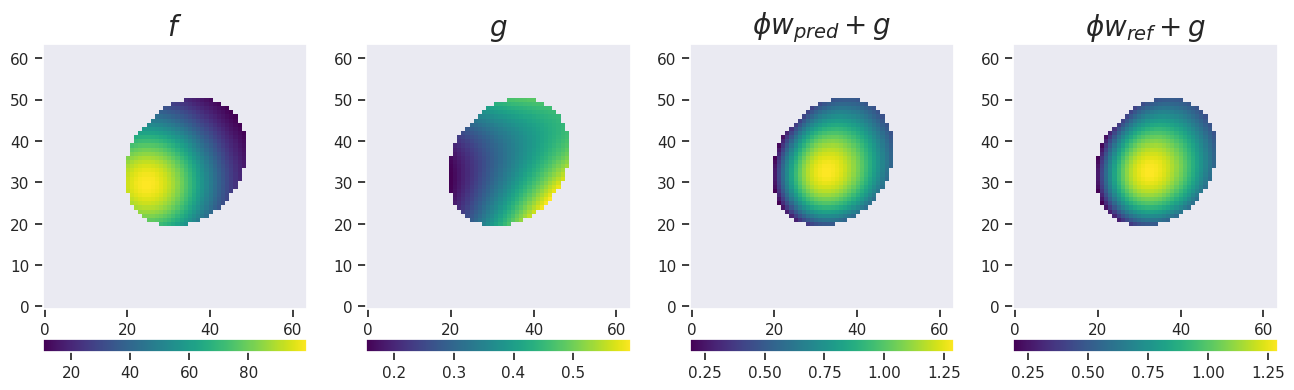

(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [0.39062768 0.47256719 0.20011963 0.54008813 0.55444617 0.21266753
 0.2644494  2.47125855 0.6381116  0.78715953]
0.000277


In [3]:
i = 2000
agent.model.load_weights(f"./models_{nb_data}/model_{i}/model_weights")
X_val, Y_val = agent.data.X_val, agent.data.Y_val
Y_pred = agent.model.call(X_val)
domain = X_val[:, :, :, -1]
nb_vert = np.shape(domain)[1]
domain_prop = tf.reduce_sum(domain, axis=[1, 2]) / nb_vert**2

diff = (
    Y_val * X_val[:, :, :, 1, None]
    + X_val[:, :, :, 2, None]
    - (Y_pred * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None])
)

L2_error = tf.sqrt(
    tf.reduce_mean(
        (diff**2) * X_val[:, :, :, -1, None],
        axis=[1, 2, 3],
    )
    / tf.reduce_mean(
        ((Y_val * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None]) ** 2)
        * X_val[:, :, :, -1, None],
        axis=[1, 2, 3],
    )
)

argmin = np.argmin(L2_error)
print(argmin)
sorted_min = sorted(range(len(L2_error)), key=lambda k: L2_error[k])
minimal_errors = sorted_min[:1]
print(minimal_errors)


Params = np.load(f"./data_{nb_data}/agentParams.npy")
data_size = np.shape(Params)[0]
nb_val = data_size // 8
nb_train = data_size - nb_val
params_val = Params[nb_train:]


for i in minimal_errors:
    X = data.X_val[i, :, :]
    F = X[:, :, 0] * data.max_norm_F
    W_ref = data.Y_val[i]
    Y = agent.model.call(X[None, :, :, :])
    domains_nan = X[:, :, -1].numpy()
    domains_nan[domains_nan == 0] = np.nan

    plt.figure(figsize=(16, 4))

    ax1 = plt.subplot(141)
    img = ax1.imshow(
        F * domains_nan, cmap=my_cmap, aspect="equal", origin="lower"
    )
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax1.grid(False)
    ax1.set_title(r"$f$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    ax2 = plt.subplot(142)
    img = ax2.imshow(
        (X[:, :, 2]) * domains_nan,
        cmap=my_cmap,
        aspect="equal",
        origin="lower",
    )
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax2.grid(False)
    ax2.set_title(r"$g$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    ax3 = plt.subplot(143)
    img = ax3.imshow(
        (Y[0, :, :, 0] * X[:, :, 1] + X[:, :, 2]) * domains_nan,
        cmap=my_cmap,
        aspect="equal",
        origin="lower",
    )
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax3.grid(False)
    ax3.set_title(r"$\phi w_{pred} + g$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    ax4 = plt.subplot(144)
    img = ax4.imshow(
        (W_ref[:, :, 0] * X[:, :, 1] + X[:, :, 2]) * domains_nan,
        cmap=my_cmap,
        aspect="equal",
        origin="lower",
    )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    ax4.grid(False)
    ax4.set_title(r"$\phi w_{ref} + g$", fontsize=20)
    plt.colorbar(img, cax=cax, orientation="horizontal")

    if save_figs:
        plt.savefig(f"./images_{nb_data}/best_prediction_{L2_error[i]:6f}.png")
    plt.show()

    params = params_val[i]
    print(
        f"(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = {params}"
    )
    print(f"{L2_error[i]:6f}")

# Erreur relative en fonction des epochs

## Jeu de validation

In [4]:
errors = []
Linf_errors = []

for i in epochs:
    agent.model.load_weights(f"./models_{nb_data}/model_{i}/model_weights")
    X_val, Y_val = agent.data.X_val, agent.data.Y_val
    Y_pred = agent.model.call(X_val)
    domain = X_val[:, :, :, -1]
    nb_vert = np.shape(domain)[1]
    domain_prop = tf.reduce_sum(domain, axis=[1, 2]) / nb_vert**2

    diff = (
        Y_val * X_val[:, :, :, 1, None]
        + X_val[:, :, :, 2, None]
        - (Y_pred * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None])
    )

    val = tf.sqrt(
        tf.reduce_mean(
            (diff**2) * X_val[:, :, :, -1, None],
            axis=[1, 2, 3],
        )
        / tf.reduce_mean(
            ((Y_val * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None]) ** 2)
            * X_val[:, :, :, -1, None],
            axis=[1, 2, 3],
        )
    )


    errors.append(val)
    Linf_errors.append(
        np.max(
            np.max(np.absolute(diff * X_val[:, :, :, -1, None]), axis=1),
            axis=1,
        )
        / np.max(
            np.max(
                np.absolute(
                    (Y_val * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None])
                    * X_val[:, :, :, -1, None]
                ),
                axis=1,
            ),
            axis=1,
        )
    )

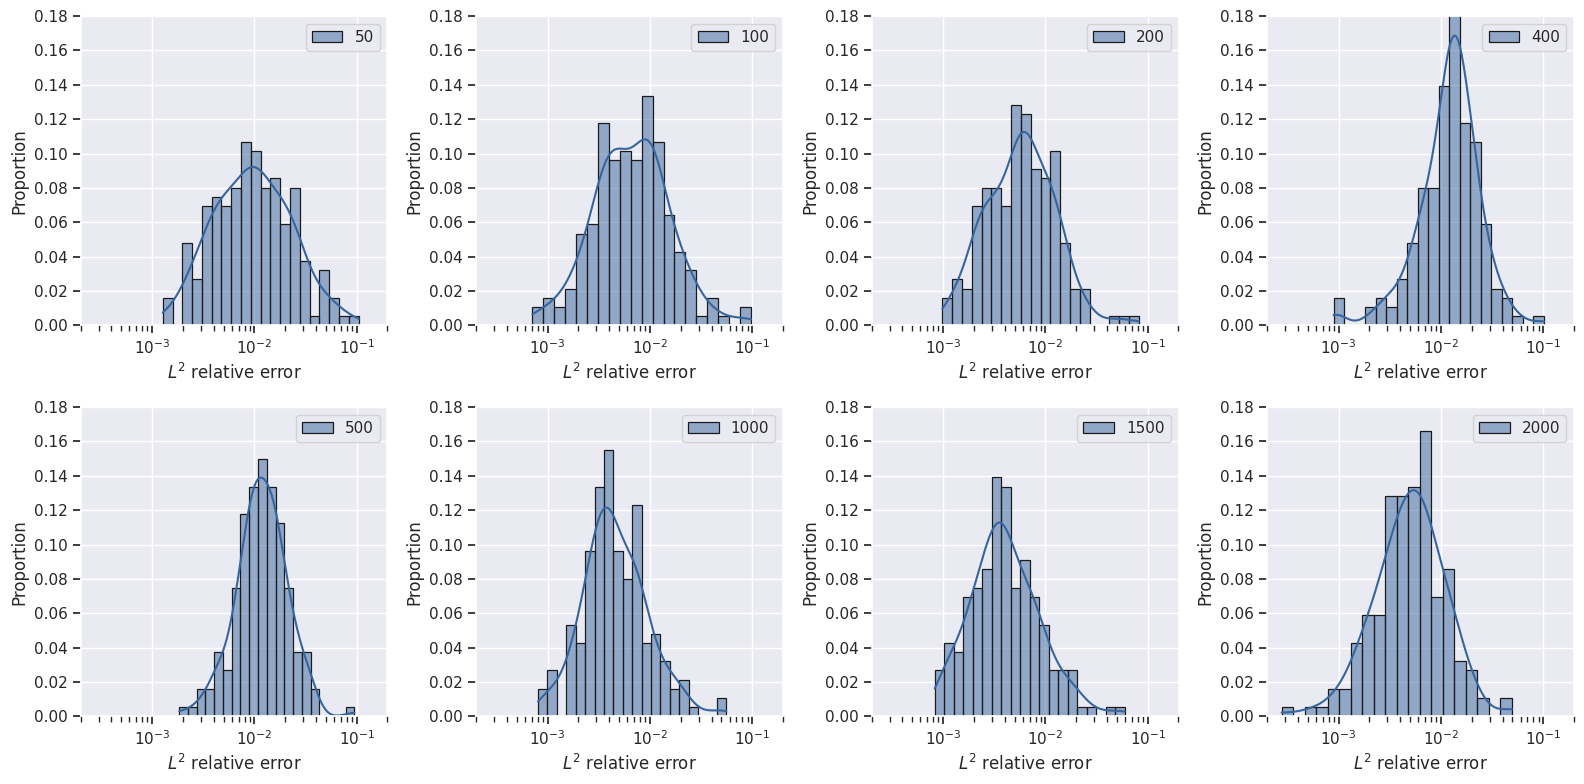

In [5]:
j, k = 0, 0
fig, axes = plt.subplots(
    nb_rows,
    size_row,
    figsize=(size_per_fig * size_row, size_per_fig * nb_rows),
)

for i in range(len(indices)):
    if k == size_row:
        k = 0
        j += 1
    sns.histplot(
        data=errors[indices[i]],
        kde=True,
        bins=20,
        color=colors[2],
        edgecolor="k",
        log_scale=True,
        label=str(epochs[indices[i]]),
        stat="proportion",
        legend=True,
        ax=axes[j, k],
    )
    axes[j, k].set_xlabel("$L^2$ relative error")
    axes[j, k].legend()
    axes[j, k].set_xlim(2e-4, 2e-1)
    axes[j, k].set_ylim(0.0, 0.18)
    k += 1

plt.tight_layout()
if save_figs:
    plt.savefig(f"./images_{nb_data}/histograms_validation_L2.png")
plt.show()

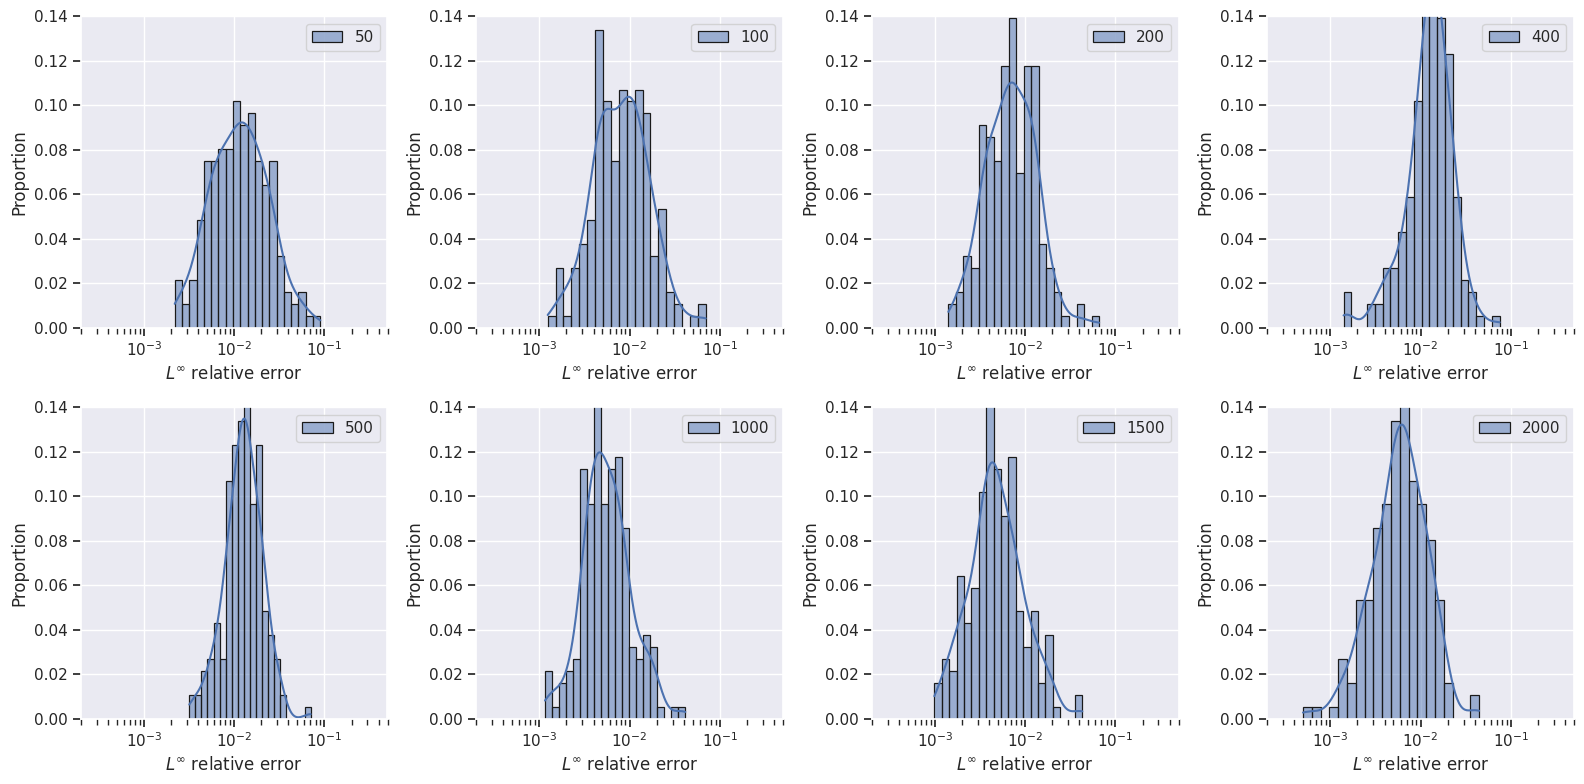

In [6]:
j, k = 0, 0
fig, axes = plt.subplots(
    nb_rows,
    size_row,
    figsize=(size_per_fig * size_row, size_per_fig * nb_rows),
)

for i in range(len(indices)):
    if k == size_row:
        k = 0
        j += 1
    sns.histplot(
        data=Linf_errors[indices[i]],
        kde=True,
        bins=20,
        color=colors[2],
        edgecolor="k",
        log_scale=True,
        label=str(epochs[indices[i]]),
        stat="proportion",
        legend=True,
        ax=axes[j, k],
    )
    axes[j, k].set_xlabel("$L^\infty$ relative error")
    axes[j, k].legend()
    axes[j, k].set_xlim(2e-4, 5e-1)
    axes[j, k].set_ylim(0.0, 0.140)
    k += 1

plt.tight_layout()
if save_figs:
    plt.savefig(f"./images_{nb_data}/histograms_validation_Linf.png")
plt.show()

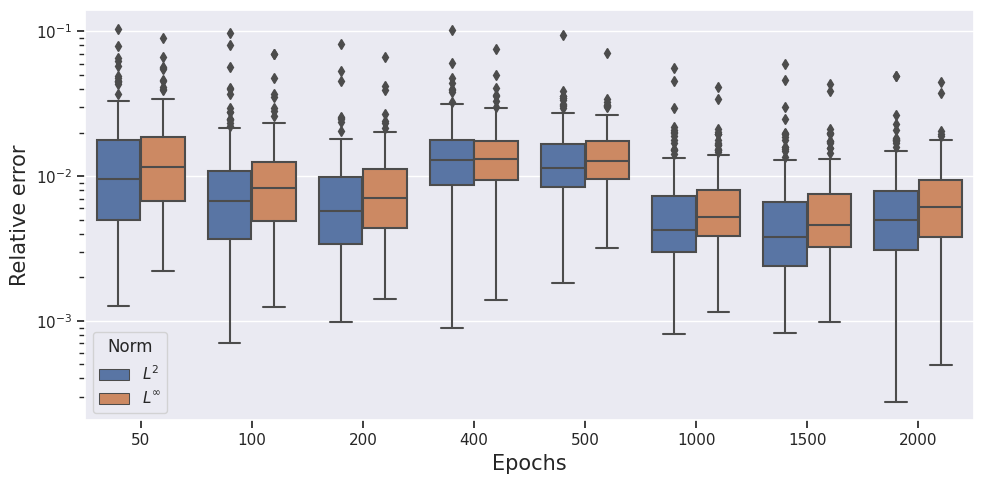

In [7]:
plt.figure(figsize=(10, 5))

"""
On crée des dataframe de la forme
|epoch|error|norm|
où type est L2 ou Linf et epoch est un multiple de 250
"""

size_val = len(errors[0])

epoch_repeat = np.array([])
for epoch in epochs:
    tab = np.repeat(str(epoch), size_val)
    epoch_repeat = np.concatenate([epoch_repeat, tab], axis=0)

tab_L2 = np.repeat(["$L^2$"], size_val * len(epochs))

errors_L2_flatten = np.array(errors).flatten()

df_array_L2 = np.stack([epoch_repeat, errors_L2_flatten, tab_L2], axis=0)

tab_Linf = np.repeat(["$L^\infty$"], size_val * len(epochs))
errors_Linf_flatten = np.array(Linf_errors).flatten()
df_array_Linf = np.stack([epoch_repeat, errors_Linf_flatten, tab_Linf], axis=0)

df_array = np.concatenate([df_array_L2, df_array_Linf], axis=1)

name = ["Epochs", "Error", "Norm"]
df_errors = pd.DataFrame(df_array.transpose(), columns=name)
df_errors = df_errors.astype(
    {"Epochs": "int", "Error": "float64", "Norm": "category"}
)

sns.boxplot(
    data=df_errors, x="Epochs", y="Error", hue="Norm", dodge=True
)  # ,palette="ch:s=.25,rot=-.25"
plt.yscale("log")
plt.ylabel("Relative error", fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.tight_layout()

if save_figs:
    plt.savefig(f"./images_{nb_data}/boxplots_validation_L2_Linf.png")
plt.show()

(8, 187)


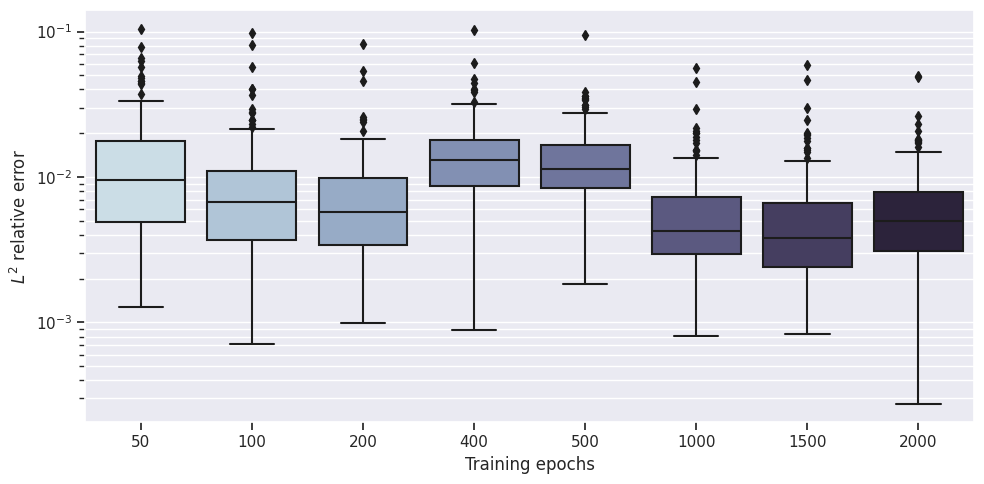

In [8]:
plt.figure(figsize=(10, 5))

errors = np.array(errors[:])
print(np.shape(errors))
dataframe = pd.DataFrame(errors.transpose(), columns=epochs)

sns.boxplot(data=dataframe, palette="ch:s=.25,rot=-.25")
plt.xlabel("Training epochs")
plt.ylabel("$L^2$ relative error")
plt.yscale("log")
plt.grid(True, "both", "y")
plt.tight_layout()
plt.savefig(f"./images_{nb_data}/boxplots_validation_epochs_L2_error.png")
plt.show()

In [9]:
epochs_means = list(i * 50 for i in range(1, 41))

print(len(epochs_means))
print(epochs_means)

errors = []
Linf_errors = []

for i in epochs_means:
    agent.model.load_weights(f"./models_{nb_data}/model_{i}/model_weights")
    X_val, Y_val = agent.data.X_val, agent.data.Y_val
    Y_pred = agent.model.call(X_val)
    domain = X_val[:, :, :, -1]
    nb_vert = np.shape(domain)[1]
    domain_prop = tf.reduce_sum(domain, axis=[1, 2]) / nb_vert**2

    diff = (
        Y_val * X_val[:, :, :, 1, None]
        + X_val[:, :, :, 2, None]
        - (Y_pred * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None])
    )

    val = tf.sqrt(
        tf.reduce_mean(
            (diff**2) * X_val[:, :, :, -1, None],
            axis=[1, 2, 3],
        )
        / tf.reduce_mean(
            ((Y_val * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None]) ** 2)
            * X_val[:, :, :, -1, None],
            axis=[1, 2, 3],
        )
    )

    errors.append(val)
    Linf_errors.append(
        np.max(
            np.max(np.absolute(diff * X_val[:, :, :, -1, None]), axis=1),
            axis=1,
        )
        / np.max(
            np.max(
                np.absolute(
                    (Y_val * X_val[:, :, :, 1, None] + X_val[:, :, :, 2, None])
                    * X_val[:, :, :, -1, None]
                ),
                axis=1,
            ),
            axis=1,
        )
    )

40
[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000]


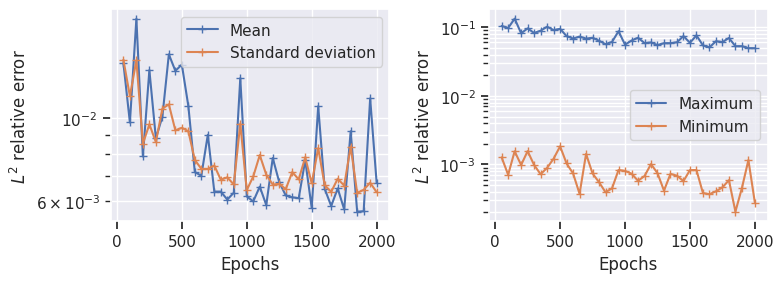

In [10]:
means = np.mean(errors, axis=1)
standard_deviation = np.std(errors, axis=1)
maxs = np.max(errors, axis=1)
mins = np.min(errors, axis=1)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.semilogy(epochs_means, means, "-+", label="Mean")
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")
plt.semilogy(
    epochs_means, standard_deviation, "-+", label="Standard deviation"
)
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")
plt.grid(True, "both", "both")
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(epochs_means, maxs, "-+", label="Maximum")
plt.semilogy(epochs_means, mins, "-+", label="Minimum")
plt.grid(True, "both", "both")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")
plt.tight_layout()

if save_figs:
    plt.savefig(f"./images_{nb_data}/min_mean_max_L2_error_epochs.png")
plt.show()

# Erreur sur un nouveau jeu de données

In [ ]:
from generate_data import PhiFemSolver

In [ ]:
u_exs, V_exs, dx_exs = [], [], []
L2_error_phi_fem, L2_error_std_fem = [], []
Temps_phi, Temps_std = [], []
F, Phi, G, params = create_FG_numpy(300, 64)
solver = PhiFemSolver(nb_cell=64 - 1, params=params)
W_phi_fem = solver.solve_several()
print(f"{np.shape(W_phi_fem)=}")

errors_fno, times_fno = [], []

for j in epochs:
    print(f"Epoch : {j}")
    agent.model.load_weights(f"./models_{nb_data}/model_{j}/model_weights")
    L2_error_fno = []
    Temps_fno = []
    X = generate_manual_new_data_numpy(Phi, F / data.max_norm_F, G)
    Y_pred = agent.model.call(X)

    domain = X[:, :, :, -1]
    nb_vert = np.shape(domain)[1]
    domain_prop = tf.reduce_sum(domain, axis=[1, 2]) / nb_vert**2
    diff = (
        W_phi_fem[:, :, :] * X[:, :, :, 1]
        + G
        - (Y_pred[:, :, :, 0] * X[:, :, :, 1] + G)
    )

    L2_error_fno = tf.sqrt(
        tf.reduce_mean(
            (diff**2) * X[:, :, :, -1] / (domain_prop[:, None, None]),
            axis=[1, 2],
        )
        / tf.reduce_mean(
            ((W_phi_fem * X[:, :, :, 1] + G) ** 2)
            * X[:, :, :, -1]
            / (domain_prop[:, None, None]),
            axis=[1, 2],
        )
    )

    errors_fno.append(L2_error_fno)

In [ ]:
j, k = 0, 0
fig, axes = plt.subplots(
    nb_rows,
    size_row,
    figsize=(size_per_fig * size_row, size_per_fig * nb_rows),
)

for i in range(len(indices)):
    if k == size_row:
        k = 0
        j += 1
    sns.histplot(
        data=errors_fno[indices[i]],
        kde=True,
        bins=20,
        color=colors[2],
        edgecolor="k",
        log_scale=True,
        label=str(epochs[indices[i]]),
        stat="proportion",
        legend=True,
        ax=axes[j, k],
    )
    axes[j, k].set_xlabel("$L^2$ relative error")
    axes[j, k].legend()
    axes[j, k].set_xlim(3e-4, 1e-1)
    axes[j, k].set_ylim(0.0, 0.17)
    k += 1

plt.tight_layout()
if save_figs:
    plt.savefig(f"./images_{nb_data}/histograms_new_data_L2.png")
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))

"""
On crée des dataframe de la forme
|epoch|error|norm|
où type est L2 ou Linf et epoch est un multiple de 250
"""

size_val = len(errors_fno[0])

epoch_repeat = np.array([])
for epoch in epochs:
    tab = np.repeat(str(epoch), size_val)
    epoch_repeat = np.concatenate([epoch_repeat, tab], axis=0)

tab_L2 = np.repeat(["$L^2$"], size_val * len(epochs))

errors_L2_flatten = np.array(errors_fno).flatten()

df_array_L2 = np.stack([epoch_repeat, errors_L2_flatten, tab_L2], axis=0)

df_array = np.concatenate([df_array_L2], axis=1)

name = ["Epochs", "Error", "Norm"]
df_errors = pd.DataFrame(df_array.transpose(), columns=name)
df_errors = df_errors.astype(
    {"Epochs": "int", "Error": "float64", "Norm": "category"}
)

sns.boxplot(
    data=df_errors, x="Epochs", y="Error", hue="Norm", dodge=True
)  # ,palette="ch:s=.25,rot=-.25"
plt.yscale("log")
plt.ylabel("Relative error")
plt.tight_layout()

save_figs = True
if save_figs:
    plt.savefig(f"./images_{nb_data}/boxplots_new_data_L2.png")
plt.show()

In [ ]:
errors, times_fno = [], []

for j in epochs_means:
    print(f"Epoch : {j}")
    agent.model.load_weights(f"./models_{nb_data}/model_{j}/model_weights")
    L2_error_fno = []
    Temps_fno = []
    X = generate_manual_new_data_numpy(Phi, F / data.max_norm_F, G)
    Y_pred = agent.model.call(X)

    domain = X[:, :, :, -1]
    nb_vert = np.shape(domain)[1]
    domain_prop = tf.reduce_sum(domain, axis=[1, 2]) / nb_vert**2
    diff = (
        W_phi_fem[:, :, :] * X[:, :, :, 1]
        + G
        - (Y_pred[:, :, :, 0] * X[:, :, :, 1] + G)
    )

    L2_error_fno = tf.sqrt(
        tf.reduce_mean(
            (diff**2) * X[:, :, :, -1] / (domain_prop[:, None, None]),
            axis=[1, 2],
        )
        / tf.reduce_mean(
            ((W_phi_fem * X[:, :, :, 1] + G) ** 2)
            * X[:, :, :, -1]
            / (domain_prop[:, None, None]),
            axis=[1, 2],
        )
    )

    errors.append(L2_error_fno)

In [ ]:
means = np.mean(errors, axis=1)
standard_deviation = np.std(errors, axis=1)
maxs = np.max(errors, axis=1)
mins = np.min(errors, axis=1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.semilogy(epochs_means, means, "-+", label="Mean")
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")
plt.semilogy(
    epochs_means, standard_deviation, "-+", label="Standard deviation"
)
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")
plt.grid(True, "both", "both")
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(epochs_means, maxs, "-+", label="Maximum")
plt.semilogy(epochs_means, mins, "-+", label="Minimum")
plt.grid(True, "both", "both")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")
plt.tight_layout()

if save_figs:
    plt.savefig(
        f"./images_{nb_data}/min_mean_max_L2_error_epochs_new_data.png"
    )
plt.show()

# New data : $\sin$

In [3]:
from generate_data import PhiFemSolver

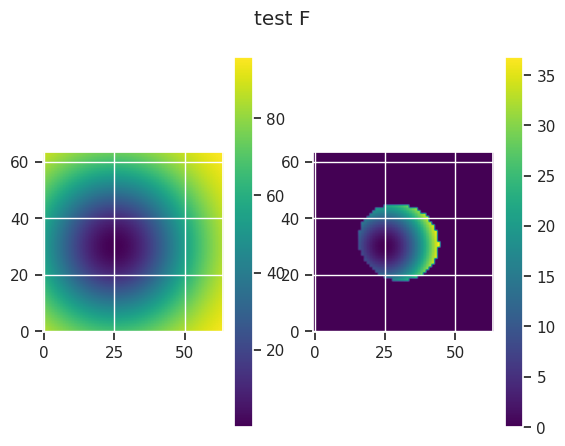

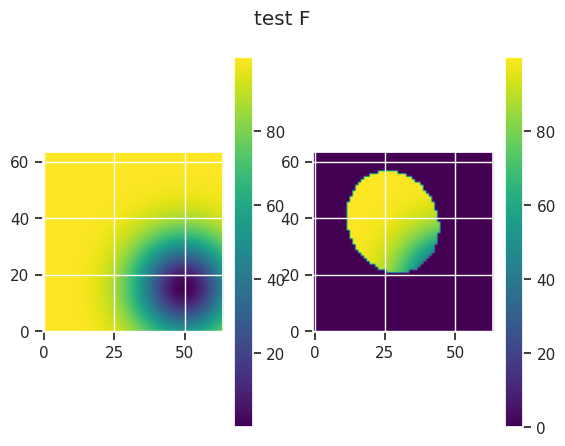

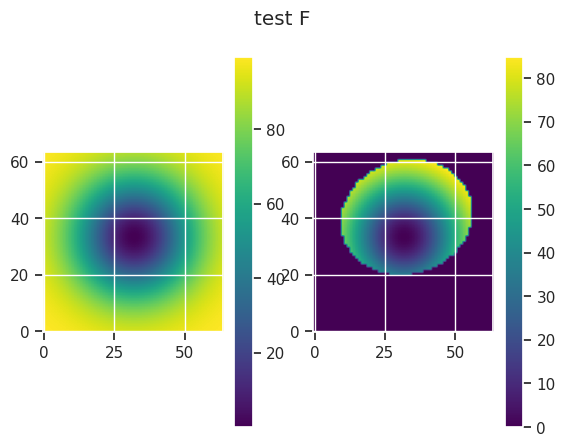

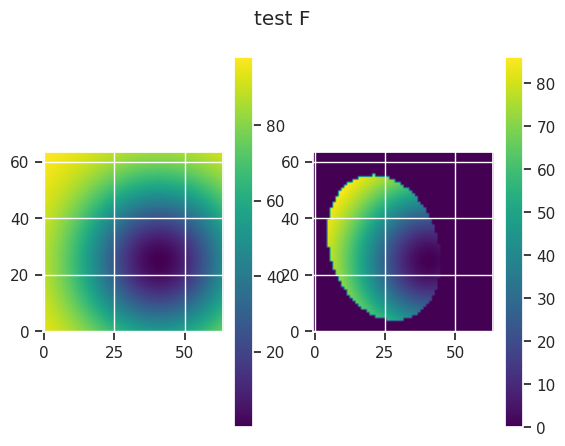

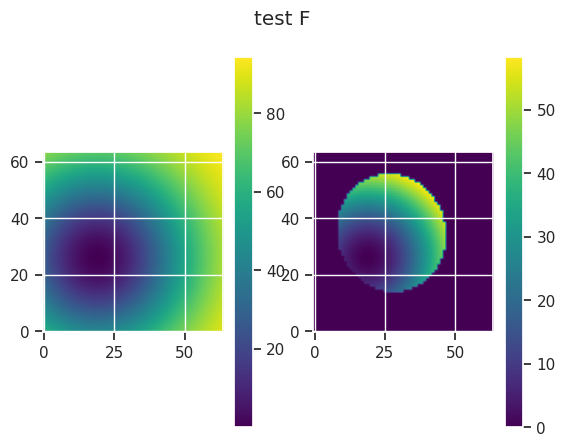

In [4]:

def call_F(pre, xy, mu0, mu1, sigma):
    return 100.0 - 100.0 * np.exp(
        -((xy[0] - mu0) ** 2 + (xy[1] - mu1) ** 2) / (2.0 * sigma**2)
    )
def call_G(pre, xy, alpha, beta):
    return np.sin(xy[0] * alpha) + (xy[0] ** 2 - xy[1] ** 2) * np.cos(
        np.pi * beta * xy[1]
    )


def call_phi(pre, xy, x_0, y_0, lx, ly, theta):
    return (
        -1.0
        + ((xy[0] - x_0) * np.cos(theta) + (xy[1] - y_0) * np.sin(theta)) ** 2
        / lx**2
        + ((xy[0] - x_0) * np.sin(theta) - (xy[1] - y_0) * np.cos(theta)) ** 2
        / ly**2
    )


def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def call_Omega(pre, xy, x_0, y_0, lx, ly, theta):
    return call_phi(pre, xy, x_0, y_0, lx, ly, theta) <= 0.0

def outside_ball(point):
    x, y = point
    return -0.45 + np.sqrt((x - 0.5) ** 2 + (y - 0.5) ** 2) > 0.0

def Omega_bool(x, y, x_0, y_0, lx, ly, theta):
    xy = (x, y)
    return call_Omega(None, xy, x_0, y_0, lx, ly, theta)


def omega_mask(nb_vert, x_0, y_0, lx, ly, theta):
    xy = np.linspace(0.0, 1.0, nb_vert)
    XX, YY = np.meshgrid(xy, xy)
    XX = np.reshape(XX, [-1])
    YY = np.reshape(YY, [-1])
    XXYY = np.stack([XX, YY])

    F = call_Omega(np, XXYY, x_0, y_0, lx, ly, theta)
    F = np.reshape(F, [nb_vert, nb_vert])
    return F.astype(np.float64)


def create_FG_numpy_sinus(nb_data, nb_vert):
    xy = np.linspace(0.0, 1.0, nb_vert)
    XX, YY = np.meshgrid(xy, xy)
    XX = np.reshape(XX, [-1])
    YY = np.reshape(YY, [-1])
    XXYY = np.stack([XX, YY])

    mu0 = np.random.uniform(0.2, 0.8, size=[nb_data, 1])
    mu1 = np.random.uniform(0.2, 0.8, size=[nb_data, 1])
    sigma = np.random.uniform(0.15, 0.45, size=[nb_data, 1])

    alpha = np.random.uniform(-0.8, 0.8, size=[nb_data, 1])
    beta = np.random.uniform(-0.8, 0.8, size=[nb_data, 1])

    x_0 = np.random.uniform(0.2, 0.8, size=[nb_data, 1])
    y_0 = np.random.uniform(0.2, 0.8, size=[nb_data, 1])
    lx = np.random.uniform(0.2, 0.45, size=[nb_data, 1])
    ly = np.random.uniform(0.2, 0.45, size=[nb_data, 1])
    theta = np.random.uniform(0.0, np.pi, size=[nb_data, 1])
    check_data = 0
    for n in range(nb_data):
        new_generation = 0
        xx_0, yy_0, llx, lly = x_0[n][0], y_0[n][0], lx[n][0], ly[n][0]
        xx0_llxp = rotate([xx_0, yy_0], [xx_0 + llx, yy_0], theta[n])
        xx0_llxm = rotate([xx_0, yy_0], [xx_0 - llx, yy_0], theta[n])
        yy0_llyp = rotate([xx_0, yy_0], [xx_0, yy_0 + lly], theta[n])
        yy0_llym = rotate([xx_0, yy_0], [xx_0, yy_0 - lly], theta[n])
        while (
            (outside_ball(xx0_llxp))
            or (outside_ball(xx0_llxm))
            or (outside_ball(yy0_llyp))
            or (outside_ball(yy0_llym))
        ):
            x_0[n][0] = np.random.uniform(0.2, 0.8, size=[1, 1])[0]
            y_0[n][0] = np.random.uniform(0.2, 0.8, size=[1, 1])[0]
            lx[n][0] = np.random.uniform(0.2, 0.45, size=[1, 1])[0]
            ly[n][0] = np.random.uniform(0.2, 0.45, size=[1, 1])[0]
            xx_0, yy_0, llx, lly = x_0[n][0], y_0[n][0], lx[n][0], ly[n][0]
            xx0_llxp = rotate([xx_0, yy_0], [xx_0 + llx, yy_0], theta[n])
            xx0_llxm = rotate([xx_0, yy_0], [xx_0 - llx, yy_0], theta[n])
            yy0_llyp = rotate([xx_0, yy_0], [xx_0, yy_0 + lly], theta[n])
            yy0_llym = rotate([xx_0, yy_0], [xx_0, yy_0 - lly], theta[n])
            new_generation += 1
        check_data += 1       

    F = call_F(np, XXYY, mu0, mu1, sigma)
    F = np.reshape(F, [nb_data, nb_vert, nb_vert])

    phi = call_phi(np, XXYY, x_0, y_0, lx, ly, theta)
    phi = np.reshape(phi, [nb_data, nb_vert, nb_vert])

    G = call_G(np, XXYY, alpha, beta)
    G = np.reshape(G, [nb_data, nb_vert, nb_vert])

    params = np.concatenate(
        [mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta], axis=1
    )
    return F, phi, G, params


def test_F():
    F, phi, G, params = create_FG_numpy_sinus(10, 64)
    mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta = params[0]
    mask = omega_mask(64, x_0, y_0, lx, ly, theta)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(F[0], cmap="viridis", origin='lower')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(mask * F[0], cmap="viridis", origin='lower')
    plt.colorbar()
    plt.suptitle("test F")
    plt.show()
    
    
for i in range(5):
    test_F()

In [8]:
u_exs, V_exs, dx_exs = [], [], []
L2_error_phi_fem, L2_error_std_fem = [], []
Temps_phi, Temps_std = [], []
F, Phi, G, params = create_FG_numpy_sinus(60, 64)
solver = PhiFemSolver(nb_cell=64 - 1, params=params)
W_phi_fem = solver.solve_several()
print(f"{np.shape(W_phi_fem)=}")

errors_fno, times_fno = [], []

for j in epochs:
    print(f"Epoch : {j}")
    agent.model.load_weights(f"./models_{nb_data}/model_{j}/model_weights")
    L2_error_fno = []
    Temps_fno = []
    X = generate_manual_new_data_numpy(Phi, F / data.max_norm_F, G)
    Y_pred = agent.model.call(X)

    domain = X[:, :, :, -1]
    nb_vert = np.shape(domain)[1]
    domain_prop = tf.reduce_sum(domain, axis=[1, 2]) / nb_vert**2
    diff = (
        W_phi_fem[:, :, :] * X[:, :, :, 1]
        + G
        - (Y_pred[:, :, :, 0] * X[:, :, :, 1] + G)
    )

    L2_error_fno = tf.sqrt(
        tf.reduce_mean(
            (diff**2) * X[:, :, :, -1] ,
            axis=[1, 2],
        )
        / tf.reduce_mean(
            ((W_phi_fem * X[:, :, :, 1] + G) ** 2)
            * X[:, :, :, -1],
            axis=[1, 2],
        )
    )

    errors_fno.append(L2_error_fno)

0/60:num of cell in the ghost penalty: 322
Solving linear variational problem.
Building point search tree to accelerate distance queries.
1/60:Computed bounding box tree with 6711 nodes for 3356 points.
num of cell in the ghost penalty: 240
Solving linear variational problem.
2/60:Building point search tree to accelerate distance queries.
Computed bounding box tree with 4389 nodes for 2195 points.
num of cell in the ghost penalty: 262
Solving linear variational problem.
Building point search tree to accelerate distance queries.
3/60:Computed bounding box tree with 4559 nodes for 2280 points.
num of cell in the ghost penalty: 270
Solving linear variational problem.
Building point search tree to accelerate distance queries.
4/60:Computed bounding box tree with 5599 nodes for 2800 points.
num of cell in the ghost penalty: 212
Solving linear variational problem.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 3305 nodes for 1653 points.
5/60:num o

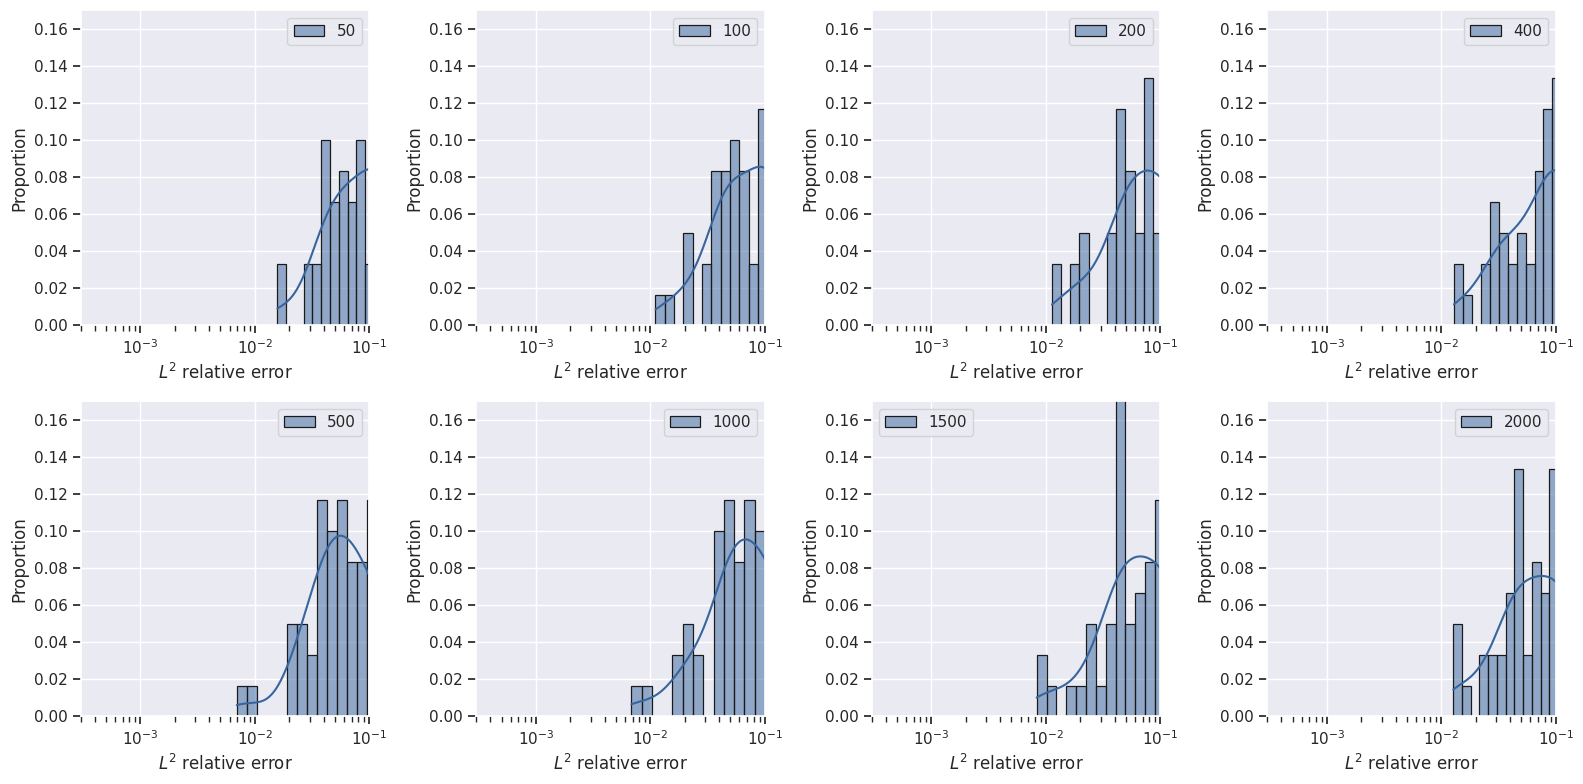

In [9]:
j, k = 0, 0
fig, axes = plt.subplots(
    nb_rows,
    size_row,
    figsize=(size_per_fig * size_row, size_per_fig * nb_rows),
)

for i in range(len(indices)):
    if k == size_row:
        k = 0
        j += 1
    sns.histplot(
        data=errors_fno[indices[i]],
        kde=True,
        bins=20,
        color=colors[2],
        edgecolor="k",
        log_scale=True,
        label=str(epochs[indices[i]]),
        stat="proportion",
        legend=True,
        ax=axes[j, k],
    )
    axes[j, k].set_xlabel("$L^2$ relative error")
    axes[j, k].legend()
    axes[j, k].set_xlim(3e-4, 1e-1)
    axes[j, k].set_ylim(0.0, 0.17)
    k += 1

plt.tight_layout()
if save_figs:
    plt.savefig(f"./images_{nb_data}/histograms_new_data_L2.png")
plt.show()

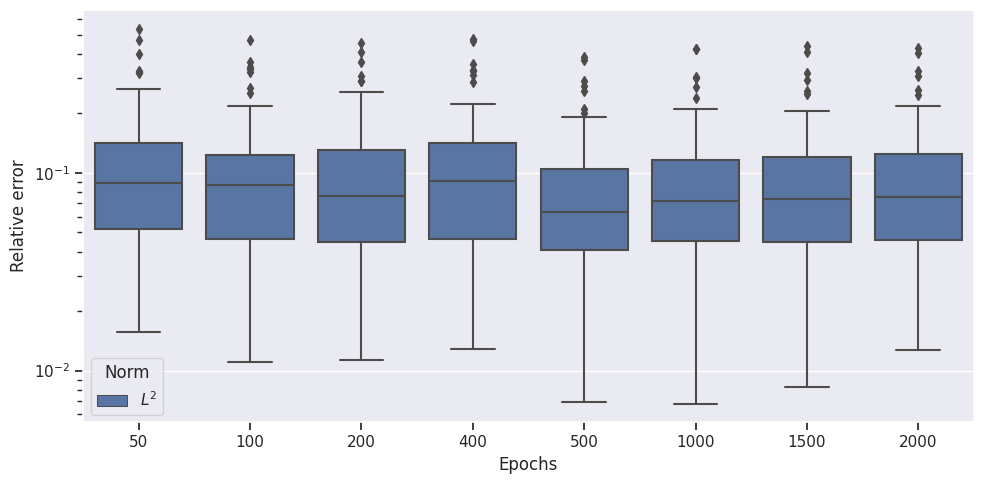

In [10]:
plt.figure(figsize=(10, 5))

"""
On crée des dataframe de la forme
|epoch|error|norm|
où type est L2 ou Linf et epoch est un multiple de 250
"""

size_val = len(errors_fno[0])

epoch_repeat = np.array([])
for epoch in epochs:
    tab = np.repeat(str(epoch), size_val)
    epoch_repeat = np.concatenate([epoch_repeat, tab], axis=0)

tab_L2 = np.repeat(["$L^2$"], size_val * len(epochs))

errors_L2_flatten = np.array(errors_fno).flatten()

df_array_L2 = np.stack([epoch_repeat, errors_L2_flatten, tab_L2], axis=0)

df_array = np.concatenate([df_array_L2], axis=1)

name = ["Epochs", "Error", "Norm"]
df_errors = pd.DataFrame(df_array.transpose(), columns=name)
df_errors = df_errors.astype(
    {"Epochs": "int", "Error": "float64", "Norm": "category"}
)

sns.boxplot(
    data=df_errors, x="Epochs", y="Error", hue="Norm", dodge=True
)  # ,palette="ch:s=.25,rot=-.25"
plt.yscale("log")
plt.ylabel("Relative error")
plt.tight_layout()

save_figs = True
if save_figs:
    plt.savefig(f"./images_{nb_data}/boxplots_new_data_L2.png")
plt.show()

In [ ]:
errors, times_fno = [], []

for j in epochs_means:
    print(f"Epoch : {j}")
    agent.model.load_weights(f"./models_{nb_data}/model_{j}/model_weights")
    L2_error_fno = []
    Temps_fno = []
    X = generate_manual_new_data_numpy(Phi, F / data.max_norm_F, G)
    Y_pred = agent.model.call(X)

    domain = X[:, :, :, -1]
    nb_vert = np.shape(domain)[1]
    domain_prop = tf.reduce_sum(domain, axis=[1, 2]) / nb_vert**2
    diff = (
        W_phi_fem[:, :, :] * X[:, :, :, 1]
        + G
        - (Y_pred[:, :, :, 0] * X[:, :, :, 1] + G)
    )

    L2_error_fno = tf.sqrt(
        tf.reduce_mean(
            (diff**2) * X[:, :, :, -1] / (domain_prop[:, None, None]),
            axis=[1, 2],
        )
        / tf.reduce_mean(
            ((W_phi_fem * X[:, :, :, 1] + G) ** 2)
            * X[:, :, :, -1]
            / (domain_prop[:, None, None]),
            axis=[1, 2],
        )
    )

    errors.append(L2_error_fno)

In [ ]:
means = np.mean(errors, axis=1)
standard_deviation = np.std(errors, axis=1)
maxs = np.max(errors, axis=1)
mins = np.min(errors, axis=1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.semilogy(epochs_means, means, "-+", label="Mean")
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")
plt.semilogy(
    epochs_means, standard_deviation, "-+", label="Standard deviation"
)
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")
plt.grid(True, "both", "both")
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(epochs_means, maxs, "-+", label="Maximum")
plt.semilogy(epochs_means, mins, "-+", label="Minimum")
plt.grid(True, "both", "both")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("$L^2$ relative error")
plt.tight_layout()

if save_figs:
    plt.savefig(
        f"./images_{nb_data}/min_mean_max_L2_error_epochs_new_data.png"
    )
plt.show()